In [1]:
from glob import glob
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import re
import nltk
from collections import defaultdict
from scipy import spatial
from IPython.display import HTML, display
import tabulate

# Dataset Prep

In [2]:
df = pd.read_excel("InputTestSet-Reviews48_Ann.xlsx")

In [3]:
df.head()

,UID,PID,Dec,Sent,MComp,Cat,SubCat
0,0,2019_SJf_XhCqKm,Reject,The authors propose to use k-DPP to select a s...,0,NaN,NaN
1,1,2019_SJf_XhCqKm,Reject,"This paper covers the related work nicely, wit...",0,NaN,NaN
2,2,2019_SJf_XhCqKm,Reject,The rest of the paper are also clearly written.,0,NaN,NaN
3,3,2019_SJf_XhCqKm,Reject,"However, I have some concerns about the propos...",0,NaN,NaN
4,4,2019_SJf_XhCqKm,Reject,"- It is not clear how to define the kernel, th...",0,NaN,NaN


In [4]:
df.shape

(1505, 7)

In [5]:
gt_dict = {}

for i in range(0, df.shape[0]):
    pid = df.loc[i]["PID"]
    if not pid in gt_dict:
        gt_dict[pid] = {"dec": df.loc[i]["Dec"], "mcomp": set(), "not_mcomp": set()}
    if df.loc[i]["MComp"] == 1:
        gt_dict[pid]["mcomp"].add(df.loc[i]["UID"])
    else:
        gt_dict[pid]["not_mcomp"].add(df.loc[i]["UID"])

In [6]:
stats_dict = {"Accept": [0, 0], "Reject": [0, 0]}

for k, v in gt_dict.items():
    #print(len(v["mcomp"]), len(v["not_mcomp"]), v["dec"])
    stats_dict[v["dec"]][0] += len(v["mcomp"])
    stats_dict[v["dec"]][1] += len(v["not_mcomp"])
    
print(stats_dict)

{'Accept': [48, 644], 'Reject': [69, 744]}


In [7]:
test_set = list(gt_dict.keys())
print("TestSet length: %d\n"%len(test_set), test_set)

TestSet length: 32
 ['2019_SJf_XhCqKm', '2017_Bk0MRI5lg', '2020_SyevYxHtDB', '2018_rJBiunlAW', '2020_rkltE0VKwH', '2018_Hki-ZlbA-', '2019_BJx0sjC5FX', '2020_r1e_FpNFDr', '2020_B1lsXREYvr', '2018_SkZxCk-0Z', '2019_rJzoujRct7', '2018_HkfXMz-Ab', '2017_BJ9fZNqle', '2019_SyxZJn05YX', '2017_B1ckMDqlg', '2017_HJ0NvFzxl', '2017_S1_pAu9xl', '2018_SyYYPdg0-', '2017_BJAA4wKxg', '2019_HyVxPsC9tm', '2019_HylTBhA5tQ', '2019_B1l08oAct7', '2018_H135uzZ0-', '2017_H1oyRlYgg', '2017_r1y1aawlg', '2020_r1eX1yrKwB', '2020_Byg79h4tvB', '2019_H1lFZnR5YX', '2020_BkeWw6VFwr', '2018_HyHmGyZCZ', '2018_HyUNwulC-', '2020_HkgsPhNYPS']


In [8]:
for k in test_set:
    print('{:20}{}'.format(k, gt_dict[k]["mcomp"]))

2019_SJf_XhCqKm     {39, 17, 20, 27, 28, 30}
2017_Bk0MRI5lg      {48, 57}
2020_SyevYxHtDB     {76, 87}
2018_rJBiunlAW      {108, 110, 112, 113, 124, 126}
2020_rkltE0VKwH     {160, 155, 184, 159}
2018_Hki-ZlbA-      {267, 235, 236, 271}
2019_BJx0sjC5FX     {292, 287}
2020_r1e_FpNFDr     {312, 322, 315, 308}
2020_B1lsXREYvr     {376, 401}
2018_SkZxCk-0Z      {449, 443, 445, 486}
2019_rJzoujRct7     {518, 519}
2018_HkfXMz-Ab      {573, 566}
2017_BJ9fZNqle      {627, 623, 615}
2019_SyxZJn05YX     {672, 673, 657, 669, 671}
2017_B1ckMDqlg      {714, 707}
2017_HJ0NvFzxl      {739}
2017_S1_pAu9xl      {792, 809, 810, 806}
2018_SyYYPdg0-      {834, 867, 868, 869, 870, 872, 873, 844, 830}
2017_BJAA4wKxg      {884}
2019_HyVxPsC9tm     {931, 933, 905, 909, 912, 913, 919, 926}
2019_HylTBhA5tQ     {972, 950}
2019_B1l08oAct7     {994, 996, 1064, 1004, 1007, 1044, 1047, 1048, 1055}
2018_H135uzZ0-      {1072, 1079}
2017_H1oyRlYgg      set()
2017_r1y1aawlg      {1125, 1162, 1100, 1102, 1168}
2020_r1eX1y

In [9]:
sents_for_test = defaultdict(list)

for i in range(0, df.shape[0]):
    pid = df.loc[i]["PID"]
    sents_for_test[pid].append((df.loc[i]["UID"], df.loc[i]["Sent"]))

# Model trained on ICLR, NeurIPS, ACL

## A. RoBERTa

In [10]:
import spacy
import torch

In [11]:
from transformers import AutoTokenizer, AutoModel

In [12]:
tokenizer = AutoTokenizer.from_pretrained("./trained_lm/CLMLModelRoBerta/")
model = AutoModel.from_pretrained("./trained_lm/CLMLModelRoBerta/")

In [13]:
def embed_text_using_roberta(text):
    input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
    outputs = model(input_ids)
    last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple
    return last_hidden_states

In [15]:
nlp = spacy.load('en_core_web_sm')
sp_toks = ["result", "method", "task", "dataset", "metric"]

In [76]:
def extract_chunks_using_spacy_dp(conssentence):
    doc = nlp(conssentence)
    verb_subtree = []

    for s in doc.sents:
        find_special_tokens = {"compar": [], "result": [], "method": [], "task": [], "dataset": [], "metric": []}

        for tok in s:

            if tok.text.lower().startswith("compar"):
                find_special_tokens["compar"].append(tok)
            else:
                for k in sp_toks:
                    if tok.text.lower().startswith(k):
                        find_special_tokens[k].append(tok)
                        break

        verb_tokens = []
        if find_special_tokens["compar"]:
            for t in find_special_tokens["compar"]:
#                     verb_subtree.append(t.subtree)
                if t == s.root:
                    simplified_sent = ""
                    for chh in t.lefts:
                        simplified_sent = simplified_sent + " " + chh.text
                    simplified_sent = simplified_sent + " " + t.text
                    for chh in t.rights:
                        simplified_sent = simplified_sent + " " + chh.text
#                         print("SIMP: ", simplified_sent)
                    verb_subtree.append(simplified_sent)
                else:
                    verb_subtree.append(t.subtree)
        else:
            for k in sp_toks:
                for i in find_special_tokens[k]:
                    local_vt = []
                    for j in i.ancestors:
                        if j.pos_ == "NOUN":
                            local_vt.append(j)
                    if not local_vt:
                        for j in i.ancestors:
                            if j.pos_ == "VERB":
                                local_vt.append(j)
                    verb_tokens = verb_tokens + local_vt


            for i in verb_tokens:
                verb_subtree.append(i.subtree)

#     print("Original Sentence: ", conssentence)
#     print("Verb SubTrees: ")
#     for i in verb_subtree:
#         print(i)
#         if type(i) == str:
#             print(i)
#         else:
#             for k in i:
#                 print(k, end=" ")
#         print("\n")
#     print("\n==============================================================================\n")
    eecc = []
    for i in verb_subtree:
        if type(i) == str:
            eecc.append(i)
        else:
            local_chunk = ""
            for lcaltok in i:
                local_chunk = local_chunk + " " + lcaltok.text
            eecc.append(local_chunk)
#     if not eecc:
#         print(conssentence)
    return eecc


In [77]:
extract_chunks_using_spacy_dp("It would be interesting to explore the practicability of the method on more large-scale experiments on image related tasks.")

[' the practicability of the method',
 ' more large - scale experiments on image related tasks']

In [95]:
extract_chunks_using_spacy_dp("The experimental validation is also not extensive since comparison to SOTA is not included.")

[' comparison to SOTA']

In [78]:
roberta_vectors = defaultdict(dict)
skip_uids = []

for pid in gt_dict:
    roberta_vectors[pid] = {}
    
    for mcs in gt_dict[pid]["mcomp"]:
#         mcomp_chunks_from_sent = extract_chunks_using_spacy_dp(df.loc[mcs]["Sent"])
#         final_chunk = ". ".join(mcomp_chunks_from_sent)
#         print(mcomp_chunks_from_sent, flush=True)

#         vec = embed_text_using_roberta(final_chunk.strip()).mean(1).detach().numpy()
#         roberta_vectors[pid][mcs] = vec / norm(vec)
        try:
            mcomp_chunks_from_sent = extract_chunks_using_spacy_dp(df.loc[mcs]["Sent"])
            if mcomp_chunks_from_sent:
                final_chunk = ". ".join(mcomp_chunks_from_sent)
            else:
                final_chunk = df.loc[mcs]["Sent"]
            
            vec = embed_text_using_roberta(final_chunk.strip()).mean(1).detach().numpy()
            roberta_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
    
    for mcs in gt_dict[pid]["not_mcomp"]:
        try:
            mcomp_chunks_from_sent = extract_chunks_using_spacy_dp(df.loc[mcs]["Sent"])
            if mcomp_chunks_from_sent:
                final_chunk = ". ".join(mcomp_chunks_from_sent)
            else:
                final_chunk = df.loc[mcs]["Sent"]
            
            vec = embed_text_using_roberta(final_chunk.strip()).mean(1).detach().numpy()
            roberta_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
        

2019_HyVxPsC9tm 938 2
2019_HyVxPsC9tm 940 3
2018_HyHmGyZCZ 1425 2


In [79]:
mcomp_sentences = {}
not_mcomp_sentences = {}

for pid in gt_dict:
    for mcs in gt_dict[pid]["mcomp"]:
        if not mcs in skip_uids:
            mcomp_sentences[mcs] = pid
    for mcs in gt_dict[pid]["not_mcomp"]:
        if not mcs in skip_uids:
            not_mcomp_sentences[mcs] = pid
print(len(mcomp_sentences), len(not_mcomp_sentences))

117 1385


In [80]:
sim_with_mcomp = defaultdict(dict)
sim_with_not_mcomp = defaultdict(dict)
sim_with_notmcomp_paper_sents = defaultdict(dict)

mean_at_k = ["1", "3", "5", "7", "10", "20", "30", "50", "100", "500", "1000", "1380"]

for sid in mcomp_sentences:
    
    # 1. With other mcomp sentences
    temp_list = []    
    for osid in mcomp_sentences:
        if osid != sid:
            temp_list.append(np.inner(roberta_vectors[mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_mcomp[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_mcomp[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])

    
    # 2. With other not_mcomp_sentences
    temp_list = []
    for osid in not_mcomp_sentences:
        temp_list.append(np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_not_mcomp[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_not_mcomp[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])

    
    # 3. With not_mcomp_sentences of the same paper
    temp_list = []    
    for osid in not_mcomp_sentences:
        if not_mcomp_sentences[osid] == mcomp_sentences[sid]:
            temp_list.append(np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_notmcomp_paper_sents[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_notmcomp_paper_sents[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])
    

### Plot

In [81]:
sim_with_mcomp[sid], sim_with_not_mcomp[sid]

({'mean': 0.44649285,
  'mean_1': 0.7566956,
  'mean_3': 0.7420221,
  'mean_5': 0.7256654,
  'mean_7': 0.71008366,
  'mean_10': 0.6805364,
  'mean_20': 0.6182237,
  'mean_30': 0.58144873,
  'mean_50': 0.53632796,
  'mean_100': 0.46725255,
  'mean_500': 0.44649285,
  'mean_1000': 0.44649285,
  'mean_1380': 0.44649285},
 {'mean': 0.38454255,
  'mean_1': 0.71290207,
  'mean_3': 0.6980513,
  'mean_5': 0.68742025,
  'mean_7': 0.6773738,
  'mean_10': 0.667991,
  'mean_20': 0.6436144,
  'mean_30': 0.62365615,
  'mean_50': 0.59844697,
  'mean_100': 0.562689,
  'mean_500': 0.46876612,
  'mean_1000': 0.4191846,
  'mean_1380': 0.3853036})

In [82]:
# mean_sim_plot
diff12 = {"all": []}
for vv in mean_at_k:
    diff12[str(vv)] = []

diff13 = {"all": []}
for vv in mean_at_k:
    diff13[str(vv)] = []

for sid in sim_with_mcomp:
    diff12["all"].append(sim_with_mcomp[sid]["mean"] - sim_with_not_mcomp[sid]["mean"])
    diff13["all"].append(sim_with_mcomp[sid]["mean"] - sim_with_notmcomp_paper_sents[sid]["mean"])
    
    for vv in mean_at_k:
        diff12[str(vv)].append(sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_not_mcomp[sid]["mean_{}".format(vv)])
        diff13[str(vv)].append(sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_notmcomp_paper_sents[sid]["mean_{}".format(vv)])


In [83]:
mean_at_k

['1', '3', '5', '7', '10', '20', '30', '50', '100', '500', '1000', '1380']

In [84]:
res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff12[val])/len(diff12[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.46,0.44,0.39,0.37,0.33,0.26,0.17,0.12,0,0.22,0.59,0.84


In [85]:
res_table

[['',
  '1',
  '3',
  '5',
  '7',
  '10',
  '20',
  '30',
  '50',
  '100',
  '500',
  '1000',
  '1380'],
 ['', 0.46, 0.44, 0.39, 0.37, 0.33, 0.26, 0.17, 0.12, 0.0, 0.22, 0.59, 0.84]]

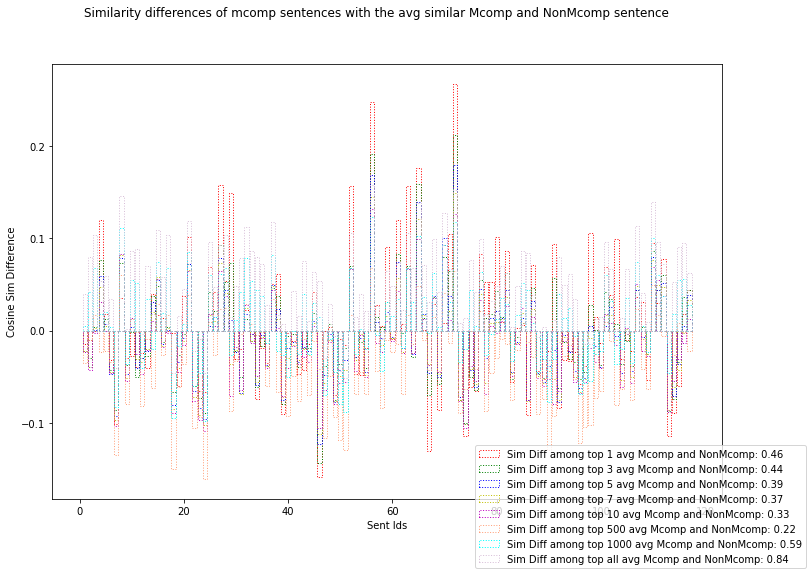

In [86]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(12,8))
cols = ['r', 'g', 'b', 'y', 'm', 'lightsalmon', 'aqua', 'thistle']
cols_idx = 0

# for mean_of_k in ["all", "10", "20", "50", "100", "500", "1000", "1380"]: #+ mean_at_k:
for mean_of_k in ["1", "3", "5", "7", "10", "500", "1000", "all"]:
    v1 = round(sum(i > 0 for i in diff12[mean_of_k])/len(diff12[mean_of_k]), 2)
    rects1 = axs.bar(list(range(1,len(diff12[mean_of_k])+1)), diff12[mean_of_k], fill=False, 
                     edgecolor=cols[cols_idx], linestyle='dotted',
                     label="Sim Diff among top {} avg Mcomp and NonMcomp: {}".format(mean_of_k, v1))
    cols_idx += 1


fig.suptitle("Similarity differences of mcomp sentences with the avg similar Mcomp and NonMcomp sentence")

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

plt.setp(axs, xlabel="Sent Ids", ylabel="Cosine Sim Difference")

plt.savefig('plots/mean_diff_roberta_at_ks_smallrange_FORCHUNKS.png', dpi=300)

In [87]:
res_table = [mean_at_k, []]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff13[val])/len(diff13[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

1,3,5,7,10,20,30,50,100,500,1000,1380
0.79,0.84,0.86,0.86,0.86,0.88,0.91,0.96,0.78,0.65,0.65,0.65


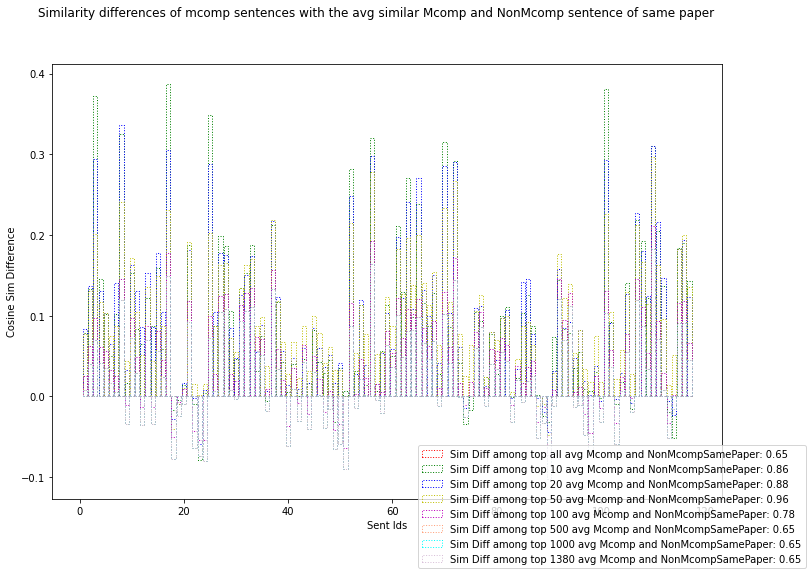

In [88]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(12,8))
cols = ['r', 'g', 'b', 'y', 'm', 'lightsalmon', 'aqua', 'thistle']
cols_idx = 0

for mean_of_k in ["all", "10", "20", "50", "100", "500", "1000", "1380"]: #+ mean_at_k:
    v1 = round(sum(i > 0 for i in diff13[mean_of_k])/len(diff13[mean_of_k]), 2)
    rects1 = axs.bar(list(range(1,len(diff13[mean_of_k])+1)), diff13[mean_of_k], fill=False, 
                     edgecolor=cols[cols_idx], linestyle='dotted',
                     label="Sim Diff among top {} avg Mcomp and NonMcompSamePaper: {}".format(mean_of_k, v1))
    cols_idx += 1


fig.suptitle("Similarity differences of mcomp sentences with the avg similar Mcomp and NonMcomp sentence of same paper")

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

plt.setp(axs, xlabel="Sent Ids", ylabel="Cosine Sim Difference")

plt.savefig('plots/mean_diff_roberta_at_ks_samepaper_FORCHUNKS.png', dpi=300)

### Analyse meaningful sentences that are more similar to NMCS in comparison to MCS.

In [89]:
ana_sim_with_mcomp = defaultdict(list)
ana_sim_with_not_mcomp = defaultdict(list)


mean_at_k = ["1", "3", "5", "7", "10", "20", "30", "50", "100", "500", "1000", "1380"]

for sid in mcomp_sentences:
    
    # 1. With other mcomp sentences
    temp_list = []    
    for osid in mcomp_sentences:
        if osid != sid:
            temp_list.append((osid, np.inner(roberta_vectors[mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0]))
    
    sorted_temp_list = sorted(temp_list, key=lambda x: x[1], reverse=True)
    ana_sim_with_mcomp[sid] = sorted_temp_list

    
    # 2. With other not_mcomp_sentences
    temp_list = []
    for osid in not_mcomp_sentences:
        temp_list.append((osid, np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0]))
    
    sorted_temp_list = sorted(temp_list, key=lambda x: x[1], reverse=True)
    ana_sim_with_not_mcomp[sid] = sorted_temp_list

In [90]:
problematic_sentences_at_k = defaultdict(list)
unproblematic_sentences_at_k = defaultdict(list)
vv = 3

for sid in sim_with_mcomp:
    sim_diff = (sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_not_mcomp[sid]["mean_{}".format(vv)])
    if sim_diff < 0:
        problematic_sentences_at_k[vv].append((sid,-1.0* sim_diff))
    else:
        unproblematic_sentences_at_k[vv].append((sid, sim_diff))

In [91]:
k = 3
sorted_problematic_sentences_at_3 = sorted(problematic_sentences_at_k[3], key=lambda x: x[1], reverse=True)
sorted(problematic_sentences_at_k[3], key=lambda x: x[1], reverse=True)[0:5]

[(657, 0.14322012662887573),
 (972, 0.1004522442817688),
 (271, 0.0893101692199707),
 (1504, 0.08690214157104492),
 (48, 0.08574169874191284)]

In [92]:
sorted_problematic_sentences_at_3[0:3], sorted_problematic_sentences_at_3[-3:]

([(657, 0.14322012662887573),
  (972, 0.1004522442817688),
  (271, 0.0893101692199707)],
 [(627, 0.00366133451461792),
  (873, 0.002418994903564453),
  (87, 0.0010606646537780762)])

In [93]:
sorted_unproblematic_sentences_at_3 = sorted(unproblematic_sentences_at_k[3], key=lambda x: x[1], reverse=True)
sorted_unproblematic_sentences_at_3[0:4], sorted_unproblematic_sentences_at_3[-4:]

([(919, 0.21184415), (834, 0.19087964), (884, 0.15892553), (312, 0.09217894)],
 [(1421, 0.0039582253),
  (20, 0.0035532713),
  (160, 0.0035532713),
  (1284, 0.00019001961)])

In [94]:
for s in sorted_problematic_sentences_at_3[0:5]:
    print("Test sent: ", df.loc[s[0]]["Sent"])
    #print("MComp Sentence under consideration: {} - {}".format(s[0], df.loc[s[0]]["Sent"]))
    
    print("\nMeaningful comparison sentences: ")
    print(ana_sim_with_mcomp[s[0]][0:3])
    for i in ana_sim_with_mcomp[s[0]][0:3]:
        print(df.loc[i[0]]["Sent"])
        #print("{}: {}".format(i[0], df.loc[i[0]]["Sent"]))
    
    print("\nNon Meaningful comparison sentence: ")
    print(ana_sim_with_not_mcomp[s[0]][0:3])
    for i in ana_sim_with_not_mcomp[s[0]][0:3]:
        print(df.loc[i[0]]["Sent"])
        #print("{}: {}".format(i[0], df.loc[i[0]]["Sent"]))
    
    print("\n\n")

Test sent:  (-) More than two datasets are necessary to show the effectiveness of the methods
comments)
- What is the higher level feature map P_m?

Meaningful comparison sentences: 
[(1079, 0.6937835), (39, 0.6450732), (443, 0.625373)]
- For reference, please include wallclock time and actual overall memory consumption comparisons of the proposed methods and other methods as well as the baseline (default FP32 training).
It would be interesting to explore the practicability of the method on more large-scale experiments on image related tasks.
Several different encoding benchmarks of the entailment task are designed to compare against the performance of the proposed model, using a newly created dataset.

Non Meaningful comparison sentence: 
[(864, 0.85275584), (1254, 0.7734018), (1257, 0.7677325)]
However, the included experiments are not nearly sufficient to establish the effectiveness of the proposed method.
The clarifications with respect to related works and missing references is he